In [629]:
import pandas as pd
import os
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import random

In [630]:
# Chage cwd
os.chdir('c:\\Users\\tyler\\OneDrive\\Documents\\Python\\MLB')
print(f'CWD: \n{os.getcwd()}')

CWD: 
c:\Users\tyler\OneDrive\Documents\Python\MLB


In [631]:
# Load schedules
schedule = pd.DataFrame()
for season in range(2022-5, 2023):
    schedule = schedule.append(pd.read_csv(f'backend/data/schedules/{season}.csv'), ignore_index=True)

schedule['date'] = pd.to_datetime(schedule['date'])
schedule = schedule.drop_duplicates(['date', 'visitor', 'home'])
schedule.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12995 entries, 0 to 13244
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   date     12995 non-null  datetime64[ns]
 1   visitor  12995 non-null  object        
 2   home     12995 non-null  object        
 3   season   12995 non-null  int64         
dtypes: datetime64[ns](1), int64(1), object(2)
memory usage: 507.6+ KB


In [632]:
# Load scores
scores = pd.read_csv('backend/data/scores/boxscore.csv')
scores['date'] = pd.to_datetime(scores['date'])
scores = scores.drop_duplicates(['date', 'visitor', 'home', 'team'])

scores.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 22080 entries, 0 to 23047
Data columns (total 26 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   date     22080 non-null  datetime64[ns]
 1   visitor  22080 non-null  object        
 2   home     22080 non-null  object        
 3   team     22080 non-null  object        
 4   1        22080 non-null  int64         
 5   2        22080 non-null  int64         
 6   3        22080 non-null  int64         
 7   4        22080 non-null  int64         
 8   5        22080 non-null  object        
 9   6        22072 non-null  object        
 10  7        22056 non-null  object        
 11  8        21838 non-null  object        
 12  9        21801 non-null  object        
 13  R        22080 non-null  int64         
 14  H        22080 non-null  int64         
 15  E        22080 non-null  int64         
 16  10       1836 non-null   float64       
 17  11       837 non-null    float6

In [633]:
scores = scores[['date', 'visitor', 'home', 'team', 'H']]
scores['opponent'] = np.where(scores['team'] == scores['home'], scores['visitor'], scores['home'])
scores['season'] = scores['date'].dt.year

df = pd.merge(
    scores, 
    scores, 
    left_on=['date', 'visitor', 'home', 'team'],
    right_on=['date', 'visitor', 'home', 'opponent'],
    suffixes=('_scored', '_allowed')
).drop(
    ['team_allowed', 'opponent_allowed', 'season_allowed'],
    axis=1
).rename(
    {'team_scored': 'team', 'opponent_scored': 'opponent', 'season_scored': 'season'},
    axis=1
)

df = df.set_index(
    ['team']
).sort_index()

df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 22080 entries, Arizona Diamondbacks to Washington Nationals
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   date       22080 non-null  datetime64[ns]
 1   visitor    22080 non-null  object        
 2   home       22080 non-null  object        
 3   H_scored   22080 non-null  int64         
 4   opponent   22080 non-null  object        
 5   season     22080 non-null  int64         
 6   H_allowed  22080 non-null  int64         
dtypes: datetime64[ns](1), int64(3), object(3)
memory usage: 1.3+ MB


New York Yankees: 747
Pittsburgh Pirates: 722
San Francisco Giants: 734
Toronto Blue Jays: 726
Pittsburgh Pirates: 722
Texas Rangers: 729


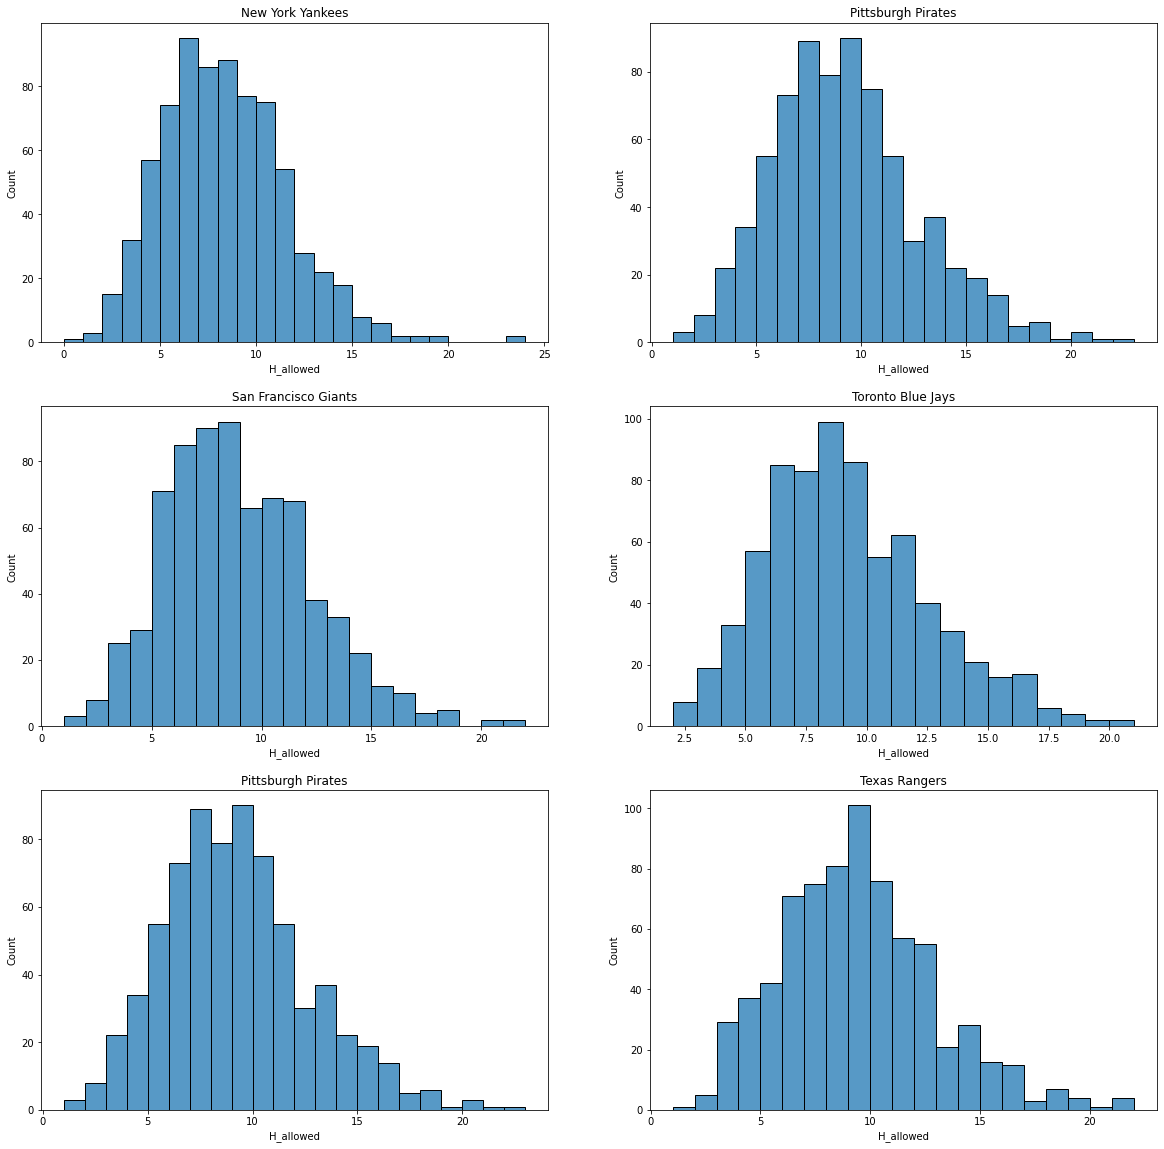

In [634]:
random.seed(5)
indices = random.choices(df.index.unique(), k=6)
fig, axs = plt.subplots(3, 2, figsize=(20, 20))
for i in range(6):
    print(f'{indices[i]}: {df.loc[indices[i]].shape[0]}')
    axs[i//2, i%2].set_title(indices[i])

    sns.histplot(data=df.loc[indices[i]].reset_index(), x='H_allowed', ax=axs[i//2, i%2], binwidth=1)

In [635]:
ma_df = pd.DataFrame()
for index in df.index.unique():
    matchup_df = df.loc[index, :].sort_values(by=['date']).copy()
    
    games=70
    min_games=70
    matchup_df['H_scored_avg'] = matchup_df['H_scored'].rolling(games, closed='left', min_periods=min_games).mean()
    matchup_df['H_scored_std'] = matchup_df['H_scored'].rolling(games, closed='left', min_periods=min_games).std()
    
    matchup_df['H_allowed_avg'] = matchup_df['H_allowed'].rolling(games, closed='left', min_periods=min_games).mean()
    matchup_df['H_allowed_std'] = matchup_df['H_allowed'].rolling(games, closed='left', min_periods=min_games).std()
    
    ma_df = ma_df.append(matchup_df.reset_index(), ignore_index=True)

ma_df = ma_df.dropna(axis=0)
ma_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 19953 entries, 70 to 22079
Data columns (total 12 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   team           19953 non-null  object        
 1   date           19953 non-null  datetime64[ns]
 2   visitor        19953 non-null  object        
 3   home           19953 non-null  object        
 4   H_scored       19953 non-null  int64         
 5   opponent       19953 non-null  object        
 6   season         19953 non-null  int64         
 7   H_allowed      19953 non-null  int64         
 8   H_scored_avg   19953 non-null  float64       
 9   H_scored_std   19953 non-null  float64       
 10  H_allowed_avg  19953 non-null  float64       
 11  H_allowed_std  19953 non-null  float64       
dtypes: datetime64[ns](1), float64(4), int64(3), object(4)
memory usage: 2.0+ MB


In [636]:
home_df = ma_df[
    ma_df['home'] == ma_df['team']
][
    [
        'date', 'visitor', 'home', 
        'H_scored_avg', 'H_scored_std', 
        'H_allowed_avg', 'H_allowed_std'
    ]
]

visitor_df = ma_df[
    ma_df['visitor'] == ma_df['team']
][
    [
        'date', 'visitor', 'home', 
        'H_scored_avg', 'H_scored_std', 
        'H_allowed_avg', 'H_allowed_std'
    ]
]

df_ma = pd.merge(
    home_df, 
    visitor_df,
    left_on=['date', 'visitor', 'home'],
    right_on=['date', 'visitor', 'home'],
    suffixes=('_home', '_visitor')
)
df_ma.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9945 entries, 0 to 9944
Data columns (total 11 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   date                   9945 non-null   datetime64[ns]
 1   visitor                9945 non-null   object        
 2   home                   9945 non-null   object        
 3   H_scored_avg_home      9945 non-null   float64       
 4   H_scored_std_home      9945 non-null   float64       
 5   H_allowed_avg_home     9945 non-null   float64       
 6   H_allowed_std_home     9945 non-null   float64       
 7   H_scored_avg_visitor   9945 non-null   float64       
 8   H_scored_std_visitor   9945 non-null   float64       
 9   H_allowed_avg_visitor  9945 non-null   float64       
 10  H_allowed_std_visitor  9945 non-null   float64       
dtypes: datetime64[ns](1), float64(8), object(2)
memory usage: 932.3+ KB


In [637]:
df = df.reset_index()
home_df = df[df['home'] == df['team']][['date', 'visitor', 'home', 'H_scored', 'H_allowed']]
visitor_df = df[df['visitor'] == df['team']][['date', 'visitor', 'home', 'H_scored', 'H_allowed']]

df_actual = pd.merge(
    home_df, 
    visitor_df,
    left_on=['date', 'visitor', 'home'],
    right_on=['date', 'visitor', 'home'],
    suffixes=('_home', '_visitor')
)

df_actual['most_hits'] = np.where(df_actual['H_scored_home'] > df_actual['H_allowed_home'], 1, 0)
df_actual['total_hits'] = df_actual['H_scored_home'] + df_actual['H_allowed_home']

df_actual.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11040 entries, 0 to 11039
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   date               11040 non-null  datetime64[ns]
 1   visitor            11040 non-null  object        
 2   home               11040 non-null  object        
 3   H_scored_home      11040 non-null  int64         
 4   H_allowed_home     11040 non-null  int64         
 5   H_scored_visitor   11040 non-null  int64         
 6   H_allowed_visitor  11040 non-null  int64         
 7   most_hits          11040 non-null  int32         
 8   total_hits         11040 non-null  int64         
dtypes: datetime64[ns](1), int32(1), int64(5), object(2)
memory usage: 819.4+ KB


In [638]:
df = pd.merge(
    df_actual,
    df_ma, 
    left_on=['date', 'visitor', 'home'],
    right_on=['date', 'visitor', 'home'],
    suffixes=('_actual', '_expected')
)

df = df[
    [
        'date', 'visitor', 'home', 'most_hits', 'total_hits', 
        'H_scored_avg_home', 'H_scored_std_home', 
        'H_allowed_avg_home', 'H_allowed_std_home',
        'H_scored_avg_visitor', 'H_scored_std_visitor', 
        'H_allowed_avg_visitor', 'H_allowed_std_visitor'
    ]
]

df.info()
df.sample(5)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9945 entries, 0 to 9944
Data columns (total 13 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   date                   9945 non-null   datetime64[ns]
 1   visitor                9945 non-null   object        
 2   home                   9945 non-null   object        
 3   most_hits              9945 non-null   int32         
 4   total_hits             9945 non-null   int64         
 5   H_scored_avg_home      9945 non-null   float64       
 6   H_scored_std_home      9945 non-null   float64       
 7   H_allowed_avg_home     9945 non-null   float64       
 8   H_allowed_std_home     9945 non-null   float64       
 9   H_scored_avg_visitor   9945 non-null   float64       
 10  H_scored_std_visitor   9945 non-null   float64       
 11  H_allowed_avg_visitor  9945 non-null   float64       
 12  H_allowed_std_visitor  9945 non-null   float64       
dtypes: 

,date,visitor,home,most_hits,total_hits,H_scored_avg_home,H_scored_std_home,H_allowed_avg_home,H_allowed_std_home,H_scored_avg_visitor,H_scored_std_visitor,H_allowed_avg_visitor,H_allowed_std_visitor
992,2020-09-16,Atlanta Braves,Baltimore Orioles,1,13,9.028571,3.702609,8.757143,3.523979,9.000000,3.814541,8.442857,3.495901
8669,2018-08-22,Kansas City Royals,Tampa Bay Rays,1,21,8.171429,3.631470,7.528571,3.408095,7.542857,2.912670,9.414286,3.307842
5640,2019-03-30,Cleveland Indians,Minnesota Twins,0,6,8.742857,3.210877,8.657143,3.619135,8.628571,4.018693,8.157143,3.638106
4749,2018-09-02,Toronto Blue Jays,Miami Marlins,0,14,8.700000,3.758469,8.828571,4.103627,8.528571,2.837234,9.485714,3.086872
5460,2019-04-15,Toronto Blue Jays,Minnesota Twins,0,16,8.871429,3.383341,8.285714,3.126061,7.914286,3.382576,8.600000,3.289861


In [639]:
df.to_csv('backend/preprocess/preprocess.csv', index=False)

<AxesSubplot:xlabel='H_scored_avg_home', ylabel='H_allowed_avg_visitor'>

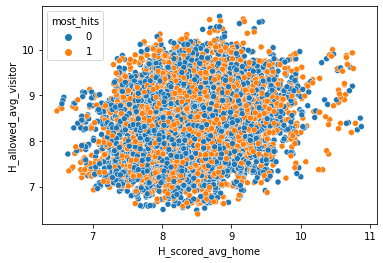

In [640]:
sns.scatterplot(
    data=df, 
    x='H_scored_avg_home', 
    y='H_allowed_avg_visitor',
    hue='most_hits'
)